In [16]:
from keras.datasets import boston_housing
from keras import models
from keras import layers

import matplotlib.pyplot as plt
import numpy as np

In [17]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [18]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


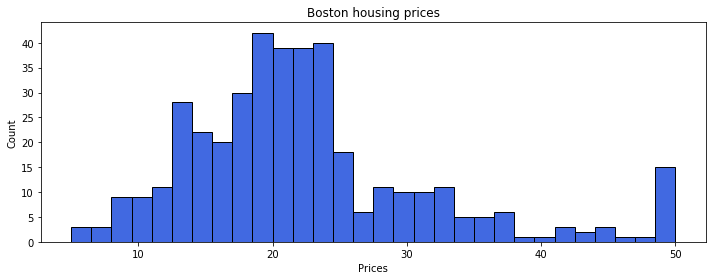

In [19]:
fig, ax = plt.subplots(1,1,figsize=(10,4))

ax.hist(train_targets, bins=30, edgecolor='black', color='royalblue')
ax.set_title('Boston housing prices')
ax.set_ylabel('Count')
ax.set_xlabel('Prices')

plt.tight_layout()
plt.show()

To ease the learning of the network, we do a feature-wise normalizartion so that the features are centered around zero and have unit variation: $\frac{x-\bar{x}}{\sigma}$. Note that the quantitites used for normalizing the test data are computed using the training data. One should never use any quantity computed on the test data.

In [20]:
train_data = (train_data-train_data.mean(axis=0))/train_data.std(axis=0)
test_data = (test_data-train_data.mean(axis=0))/train_data.std(axis=0)

**Network architecture**

- *```Intermediate layers```*: Because there are so little samples available, we only use two hidden layers with, each with 64 units. 


- *```Last layer```*: The network ends with a single unit without an activation function, therefore being a linear layer. A typical set up for a scalar regression. Any activation function, say the sigmoid function for example, will constrain the range the output can take [0,1].


- *```Loss function```*: MSE, very typical for regression problem, wraps up the network, while also monitoring MAE. Here, MAE of 0.5 would mean that the predictions are off by $500.

In [21]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

As there is so little data, splitting data into training and validation sets the validation set would end up being really small. As a consequence, the validation scores might change a lot depending on which data points we choose for validation and which we choose for training meaning that the validation scores might have high variance with regard to validation split. Therefore, we apply K-fold cross-validation.

In [22]:
k = 4
num_val_samples = len(train_data) // k 
num_epochs = 100
all_scores = []

for i in range(k):
    # Validation data ki = {k1 ..k4}
    print('processing fold {:d}'.format(i))
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    # Training data K-1, remaining partions
    X_train = np.concatenate([train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
    y_train = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis=0)

    # Train the model
    model = build_model()
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold 0
processing fold 1
processing fold 2
processing fold 3


In [23]:
print(all_scores)
print(np.mean(all_scores))

[2.3510615825653076, 2.3277478218078613, 2.8290085792541504, 2.416227102279663]
2.4810112714767456


The different k-fold runs do indeed show rather dfferent validation scores, ranging from 2.33 to 2.83 According to the mean score, we are off by approximately 2.48 = 2480$ on average, which is quite significant considering the price range of 5000 to 50000. Training the network a bit longer could help so let's consider 300 epochs. To keep record of how well the model does at each epoch, we'll modify the loop a bit to save the per-epoch validation score log.

In [25]:
num_epochs = 300
all_mae_histories = []

for i in range(k):
    # Validation data ki = {k1 ..k4}
    print('processing fold {:d}'.format(i))
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    # Training data K-1, remaining partions
    X_train = np.concatenate([train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
    y_train = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis=0)

    # Train the model
    model = build_model()
    history = model.fit(X_train, y_train, validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold 0
processing fold 1
processing fold 2
processing fold 3


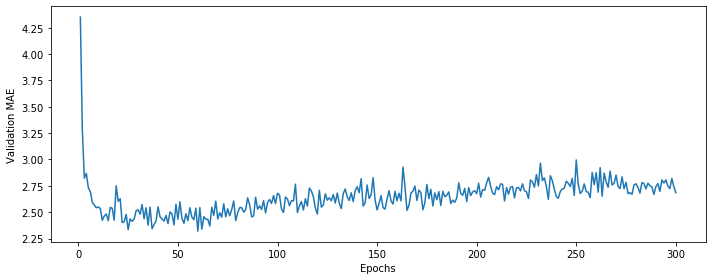

In [26]:
fig, ax = plt.subplots(1,1,figsize=(10,4))

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
ax.plot(range(1, len(average_mae_history) +1),average_mae_history)
ax.set_ylabel('Validation MAE')
ax.set_xlabel('Epochs')

plt.tight_layout()
plt.show()

In [29]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

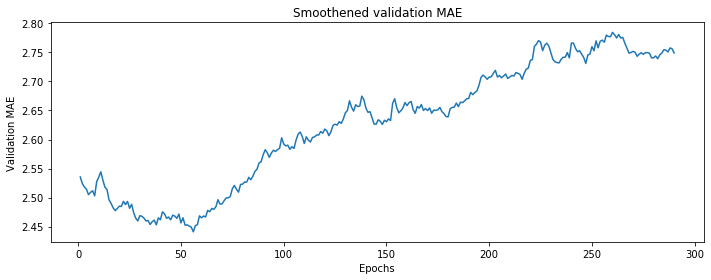

In [32]:
fig, ax = plt.subplots(1,1,figsize=(10,4))

smooth_mae_history = smooth_curve(average_mae_history[10:])
ax.plot(range(1, len(smooth_mae_history) +1), smooth_mae_history)
ax.set_title('Smoothened validation MAE')
ax.set_ylabel('Validation MAE')
ax.set_xlabel('Epochs')

plt.tight_layout()
plt.show()

In [ ]:
ax.plot(range(1, len(average_mae_history[10:]) +1), average_mae_history[10:])
ax.set_ylabel('Validation MAE')
ax.set_xlabel('Epochs')

plt.tight_layout()
plt.show()

According to the plot, validation MAE stop improving after around 60 epochs and past that point the network starts to overfit. 

In [31]:
model = build_model()
model.fit(train_data, train_targets, epochs=60, batch_size=16,verbose=0)
test_mse, test_mae = model.evaluate(test_data, test_targets)
test_mae

102/102 [==============================] - 0s 897us/step


1934.8343505859375

After reducing the number of epochs to 80 we are now off by only approximately 1934$ 